1.0. Install Dependencies and Setup

In [2]:
!pip install tensorflow opencv-python matplotlib

In [3]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binary

In [4]:
import tensorflow as tf
import os

1.1. Remove Dodgy Image

In [5]:
import cv2
import imghdr # allows to check file extensions 
from matplotlib import pyplot as plt

In [6]:
data_dir = 'data' #variable to hold path to data directory

In [7]:
image_extensions = ['jpeg','jpg', 'bmp', 'png'] #list of standard image file extensions

In [8]:
# for loop - looping through directory and then every image to check if they can be used by cv2 and imghdr if not then they are removed
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) #not a valid image
            tip = imghdr.what(image_path) #not a valid image extension
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

2.0. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
#Build the data pipeline
data = tf.keras.utils.image_dataset_from_directory('data') 

Found 336 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator() #access the generator from data pipeline - allowing us to loop through data pipeline

In [12]:
batch = data_iterator.next() #accessing the data piepline itself

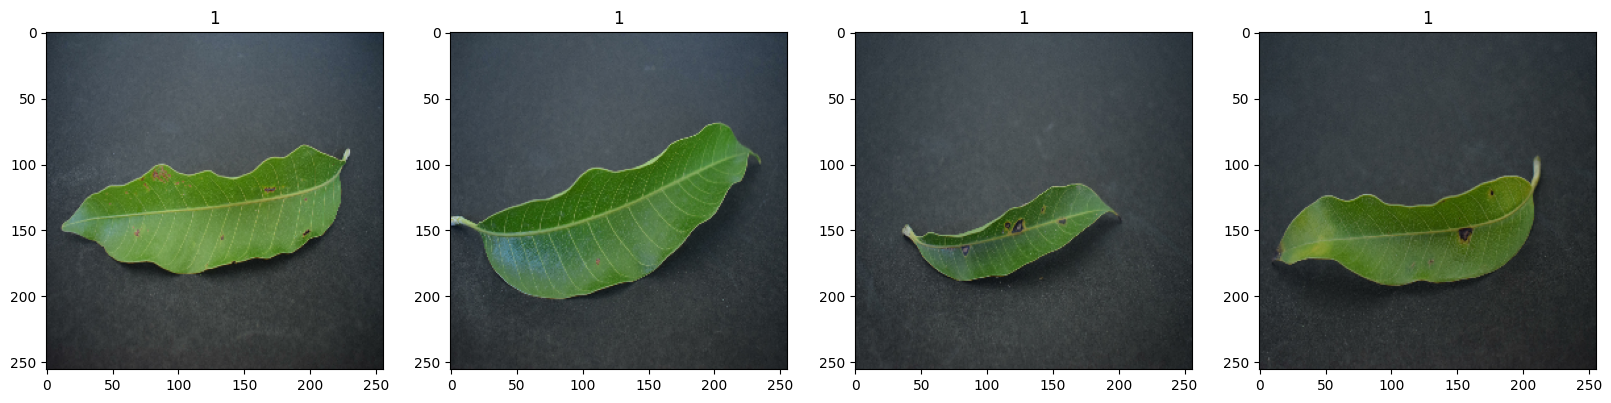

In [13]:
# for loop - looping through the images and classifying them as healthy = 0 and unhealthy = 1
#shows the classifications 0=healthy, 1 = unhealthy
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

3.0. Pre-Processing Data

3.1. Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y)) #map - applies a particular transformation as data is being preprocessed by the data pipeline... x = images, y = target values

In [15]:
scaled_iterator=data.as_numpy_iterator()

In [16]:
batch = scaled_iterator.next()

In [17]:
#CHECK FOR BATCH MAX AND MIN 0 - 1
#batch [0].min()
#batch [0].max()

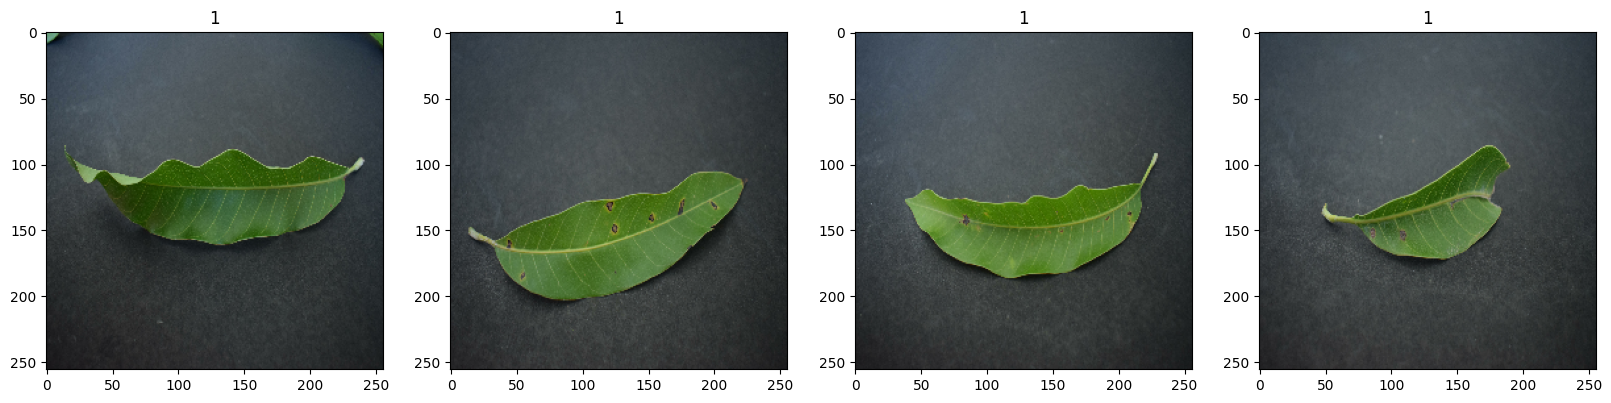

In [18]:
#CHECK IF IMAGES ARE LOADED AND SCALED
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    #shows the classifications healthy = 0 and unhealthy = 1

3.2. Split Data

In [19]:
#CHECK LENGHT OF DATA
#len(data)

In [20]:
#Partitian Allocation
train_size = int(len(data)*.7) #training will be 70% of data
val_size = int(len(data)*.2) #20% for validation
test_size = int(len(data)*.1+1) #10% testing + 1 because the data is an uneven number

In [21]:
#CHECK that it is equal to length
train_size+val_size+test_size 

11

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

4.0. Deep Learning Model

4.1. Build Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
#Adding layers sequestially
#16 = Number of filters
#3,3 = Size of filter
#1 Stride (one pixel and then moves onto the next pixel)
#activitation that gets applied - relu activation - taking the output from the convolution layer and passing it through the relu function - preserve the positive values - allows us to take into account the non linear values 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) #condenses the data down

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu')) #fully connected layers
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

4.2. Train

In [28]:
from tensorflow.keras.callbacks import TensorBoard

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val) #fit is the training function

Epoch 1/20
7/7 [==============================] - 22s 2s/step - loss: 0.7270 - accuracy: 0.6071 - val_loss: 0.6221 - val_accuracy: 0.5938
Epoch 2/20
7/7 [==============================] - 19s 2s/step - loss: 0.5647 - accuracy: 0.7143 - val_loss: 0.4270 - val_accuracy: 0.9219
Epoch 3/20
7/7 [==============================] - 24s 3s/step - loss: 0.2619 - accuracy: 0.9777 - val_loss: 0.1270 - val_accuracy: 0.9688
Epoch 4/20
7/7 [==============================] - 28s 3s/step - loss: 0.1173 - accuracy: 0.9598 - val_loss: 0.0357 - val_accuracy: 0.9844
Epoch 5/20
7/7 [==============================] - 29s 3s/step - loss: 0.0263 - accuracy: 0.9955 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 31s 3s/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 29s 3s/step - loss: 0.0952 - accuracy: 0.9643 - val_loss: 0.4350 - val_accuracy: 0.8594
Epoch 8/20
7/7 [==================

4.3. Plot Performance

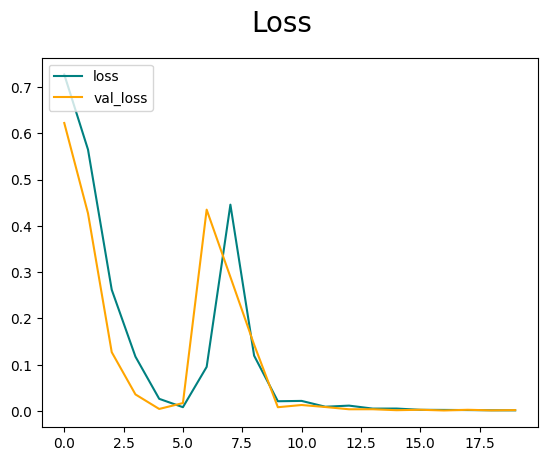

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

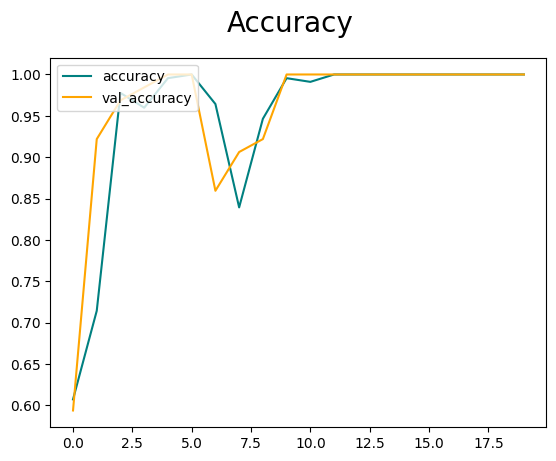

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

5.0 Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 314ms/step


In [37]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy: 1.0


6.0 Test